# DLA simulation

---

In this notebook I am simulating [diffusion limited aggregation](https://en.wikipedia.org/wiki/Diffusion-limited_aggregation), and calculate the objects fractal dimension.


### Description of the simulation

Steps:

- start with an aggregate made of one point.
- release particles randomly on a circle outside the bounding box of the aggregate.
- simluate Brownian motion until the particle reaches the aggregate, or it goes outside a larger circle.

I decided to implement the aggregate as a dictionary. The keys are the coordinates, and the values show the indices of the particles (temporal order). I find it more intuitive and flexibe than storing a grid.

### Calculating the objects  fractal dimension

I calculate the objects fractal dimension using the [Correlation dimension](https://en.wikipedia.org/wiki/Correlation_dimension).


### Calculating the objects multifractal spectrum

Simply using the definition, and multiple pivot points.

Some articles with results:

* Vicsek, T., F. Family, and P. Meakin. "Multifractal geometry of diffusion-limited aggregates." EPL (Europhysics Letters) 12.3 (1990): 217.
* Kamer, Yavor, Guy Ouillon, and Didier Sornette. "Barycentric fixed-mass method for multifractal analysis." Physical Review E 88.2 (2013): 022922.

---

*Author: Dezso Ribli*

In [1]:
import matplotlib.pyplot as plt
import random
import math
import scipy
import scipy.optimize
import scipy.spatial
import numpy as np
import pickle
from ipywidgets import interact
%matplotlib inline

In [2]:
from grow import grow,seed_circle

def aggplot(N):
    """Plot aggragate after N particles added."""
    # get x,y points in the order they were added!
    x,y = zip(*sorted(agg, key=agg.get)) 
    plt.figure(figsize=(9,9)) # square plot
    plt.plot(x[:N],y[:N],'.',ms=2)
    plt.xlim(min(x),max(x)) # fix size for better interactivity
    plt.ylim(min(y),max(y))
    plt.axis('off')
    plt.show() # somehow needed (?), its a workaround
    
    
def corr_dim(agg,a=10,L=10,plot=True):
    """Return and (plot) correlation dimension."""
    x,y = zip(*agg) # get x,y points 
    xy = np.column_stack((np.array(x),np.array(y))) # pack them
    dl = scipy.spatial.distance.pdist(xy) # get all pairwise dist
    
    dl = dl[dl<seed_circle(agg)[1]/L] # limit for the size of agg/L
    r = np.log10(np.sort(dl)) # log dist
    c = np.log10(np.arange(1,len(r)+1)) # log number of dist under r
    
    #lower limit a
    rf=r[r>np.log10(a)]
    cf=c[r>np.log10(a)]

    # fit linear on log log
    (a,b),pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b,rf,cf)

    r = r[::len(r)/int(1e4)]  # do not plot all points
    c = c[::len(c)/int(1e4)]
    
    if plot: #plot it if asked for
        plt.plot(r,c,'x')
        lab = 'coef = '+ "%.2f +/- %.2f"% (a, pcov[0,0]**0.5)
        plt.plot(r, a*r+b, label=lab)
        plt.xlabel('log10(r)')
        plt.ylabel('log10(N(<r))')
        plt.ylim(2) # lot of small dists, do not show them
        plt.legend()
        plt.grid()
    return a

### Create a small aggregate and plot it

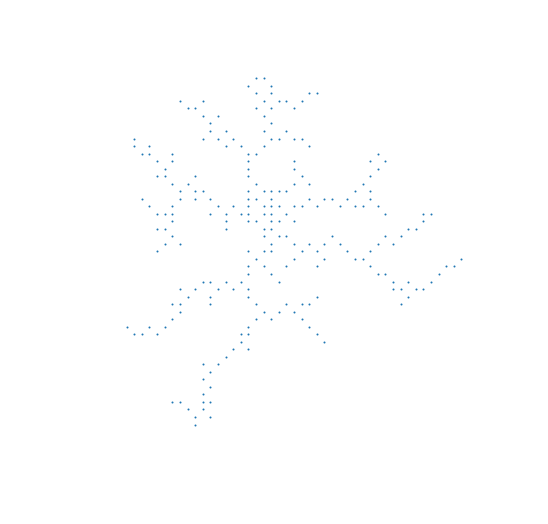

CPU times: user 1.55 s, sys: 103 ms, total: 1.65 s
Wall time: 1.58 s


In [3]:
%%time
N = 1000
agg = grow(npart=N) # create the aggregate
print 'Out of ',N,' particles, ', len(agg), 'landed in the aggregate'
_=interact(aggplot,N=(0,len(agg),1)) # interactive plot for growing agg

### Load a larger one

In [4]:
%%bash
# ./grow.py  # create it in a scipt, its slow

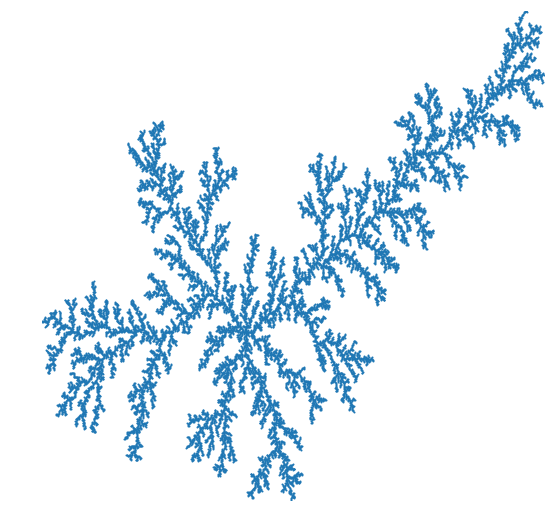

In [5]:
agg = pickle.load(open('agg.pkl','rb'))
_=interact(aggplot,N=(0,len(agg),1)) # interactive plot for growing agg

---

## Calculate correlation dimension



CPU times: user 4.84 s, sys: 2.18 s, total: 7.02 s
Wall time: 7.24 s


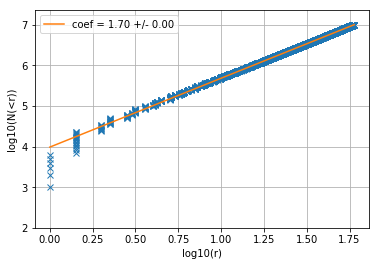

In [6]:
%%time
_=corr_dim(agg)

---


## Plot multifractal spectrum


This is slow.


In [7]:
%%bash
# ./dq.py

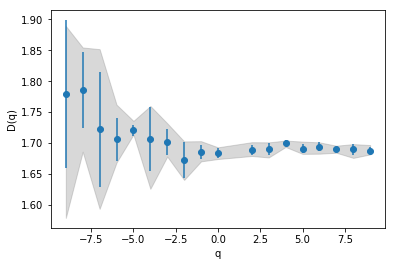

In [8]:
q, Dq = pickle.load(open('Dq.pkl','rb'))
plt.errorbar(q,np.mean(Dq,axis=0),np.std(Dq,axis=0),fmt='o')
plt.fill_between(q,np.min(Dq,axis=0),np.max(Dq,axis=0),color='gray',alpha=0.3)
plt.xlabel('q')
_=plt.ylabel('D(q)')

---

## Discussion

* The simluated aggregate looks right
* The calculated dimension is just a bit different from 1.71
* The D(q) curve is a bit different again than in the literature.